<a href="https://colab.research.google.com/github/deepakri201/prostateDataCuration/blob/main/Undertanding_Patricks_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code to understand Patrick's dataset, and how many T2/DWI/ADC series are in each study. How to choose the best one for AI models for protate cancer segmentation?

# Parameterization

In [1]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "bwh-at-ncigt-data-m-1641244486" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment

In [2]:
import os
import sys

from google.cloud import bigquery
from google.cloud import storage

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Query and plots

In [3]:
client = bigquery.Client(project=project_name)

query = f"""
-- Find the studies with T2, DWI and ADC
-- To do:
  -- Need to start with patients that have both preop and intraop ...
  -- Array_agg instead of string_agg for ease of viewing
  -- Use regexp instead of LIKE operator
  -- Include OHIF links to each study
  -- Refine rules/simplify for DWI and ADC, examine these separately
  -- Add DCE
-- To think about:
  -- How to choose the "best" T2/DWI/ADC sequence out of the list
----------------------------------------------------------------------

-- Get the distinct studyUIDs, and the possible SeriesDescriptions
-- for t2 and ax
WITH select_T2_axial_studies AS(

  SELECT
    DISTINCT(StudyInstanceUID) as StudyInstanceUID,
    STRING_AGG(DISTINCT(SeriesDescription)) as SeriesDescription_T2_AX,
    COUNT(DISTINCT(SeriesDescription)) as num_t2_ax_series
  FROM
    `bwh-at-ncigt-data-m-1641244486.mgb_cre3_irb2020p003809.dicom_metadata_March2023`
  WHERE
    LOWER(SeriesDescription) LIKE "%t2%" AND
    LOWER(SeriesDescription) LIKE "%ax%" AND
    LOWER(SeriesDescription) NOT LIKE "%diff%" AND
    LOWER(SeriesDescription) NOT LIKE "%guidance%" AND
    LOWER(SeriesDescription) NOT LIKE "%guidence%" AND
    LOWER(SeriesDescription) NOT LIKE "%template%"
  GROUP BY
    StudyInstanceUID
  ORDER BY
    num_t2_ax_series DESC

),

-- Select the DWI series that also have T2
-- Make sure "apparent" or "coefficient" are not in the names for the DWI sequences
select_DWI_studies AS(
  SELECT
    DISTINCT(select_T2_axial_studies.StudyInstanceUID),
    select_T2_axial_studies.SeriesDescription_T2_AX,
    select_T2_axial_studies.num_t2_ax_series,
    STRING_AGG(DISTINCT(dicom_metadata.SeriesDescription)) as SeriesDescription_DWI,
    COUNT(DISTINCT(dicom_metadata.SeriesDescription)) as num_dwi_series
  FROM
    select_T2_axial_studies
  JOIN
    `bwh-at-ncigt-data-m-1641244486.mgb_cre3_irb2020p003809.dicom_metadata_March2023` AS dicom_metadata
  ON
    select_T2_axial_studies.StudyInstanceUID = dicom_metadata.StudyInstanceUID
  WHERE
    (LOWER(dicom_metadata.SeriesDescription) LIKE "%dwi%" AND
    LOWER(dicom_metadata.SeriesDescription) NOT LIKE "%apparent%" AND
    LOWER(dicom_metadata.SeriesDescription) NOT LIKE "%adc%" AND
    UPPER(dicom_metadata.SeriesDescription) NOT LIKE "%ADC%" AND
    LOWER(dicom_metadata.SeriesDescription) NOT LIKE "%trace%" AND
    UPPER(dicom_metadata.SeriesDescription) NOT LIKE "%TRACE%")
    OR
    (LOWER(dicom_metadata.SeriesDescription) LIKE "%diffusion%" AND
    LOWER(dicom_metadata.SeriesDescription) NOT LIKE "%apparent%" AND
    LOWER(dicom_metadata.SeriesDescription) NOT LIKE "%adc%" AND
    UPPER(dicom_metadata.SeriesDescription) NOT LIKE "%ADC%" AND
    LOWER(dicom_metadata.SeriesDescription) NOT LIKE "%trace%" AND
    UPPER(dicom_metadata.SeriesDescription) NOT LIKE "%TRACE%")
  GROUP BY
    select_T2_axial_studies.StudyInstanceUID,
    select_T2_axial_studies.SeriesDescription_T2_AX,
    select_T2_axial_studies.num_t2_ax_series
)

-- Select the ADC series that also have T2 and DWI
SELECT
  DISTINCT(select_DWI_studies.StudyInstanceUID),
  select_DWI_studies.SeriesDescription_T2_AX,
  select_DWI_studies.num_t2_ax_series,
  select_DWI_studies.SeriesDescription_DWI,
  select_DWI_studies.num_dwi_series,
  STRING_AGG(DISTINCT(dicom_metadata.SeriesDescription)) as SeriesDescription_ADC,
  COUNT(DISTINCT(dicom_metadata.SeriesDescription)) as num_adc_series,
  ANY_VALUE(CONCAT("https://idc-tester-dk.web.app/projects/bwh-at-ncigt-data-m-1641244486/locations/us-central1/datasets/mgb-cre3-irb2020p003809/dicomStores/dicom-March2023/study/", select_DWI_studies.StudyInstanceUID)) as viewer_url
FROM
  select_DWI_studies
JOIN
  `bwh-at-ncigt-data-m-1641244486.mgb_cre3_irb2020p003809.dicom_metadata_March2023` AS dicom_metadata
ON
  select_DWI_studies.StudyInstanceUID = dicom_metadata.StudyInstanceUID
WHERE
  ((LOWER(dicom_metadata.SeriesDescription) LIKE "%apparent%" AND LOWER(dicom_metadata.SeriesDescription) LIKE "%coefficient%") OR
  LOWER(dicom_metadata.SeriesDescription) LIKE "%adc" OR
  UPPER(dicom_metadata.SeriesDescription) LIKE "%ADC%") # AND
  # num_t2_ax_series > 1
GROUP BY
  select_DWI_studies.StudyInstanceUID,
  select_DWI_studies.SeriesDescription_T2_AX,
  select_DWI_studies.num_t2_ax_series,
  select_DWI_studies.SeriesDescription_DWI,
  select_DWI_studies.num_dwi_series
ORDER BY
  select_DWI_studies.num_t2_ax_series DESC;
  """


job_config = bigquery.QueryJobConfig()
df = client.query(query, job_config=job_config).to_dataframe()

In [4]:
df

,StudyInstanceUID,SeriesDescription_T2_AX,num_t2_ax_series,SeriesDescription_DWI,num_dwi_series,SeriesDescription_ADC,num_adc_series,viewer_url
0,000069.00003224.0000037382.00000000038655,"AX TSE T2 2FZ 2MIN,AX TSE T2 1FZ 2MIN,AX TSE T...",9,resolve SEGMENTED DWI- B=0 &1400 sec x mm-2 NO...,1,resolve SEGMENTED DWI- B=0 &1400 sec x mm-2 NO...,1,https://idc-tester-dk.web.app/projects/bwh-at-...
1,000069.00012365.0000021554.00000000022020,"STRAIGHT AX T2 THINS,T2 AXIAL RESTORE,AXIAL HA...",4,AX DIFFUSION,1,AX DIFFUSION_ADC,1,https://idc-tester-dk.web.app/projects/bwh-at-...
2,000069.00012308.0000021489.00000000021955,"Axial FS T2...4mm,Axial T2...4mm,Axial FS T2.....",3,Axial Diffusion (0/800/1000),1,Axial Diffusion (0/800/1000)_ADC,1,https://idc-tester-dk.web.app/projects/bwh-at-...
3,000069.00012366.0000038219.00000000039495,"Axial T2...4mm,Axial FS T2...4mm,Axial FS T2 (...",3,Axial Diffusion (0/800/1000),1,Axial Diffusion (0/800/1000)_ADC,1,https://idc-tester-dk.web.app/projects/bwh-at-...
4,000069.00001211.0000037445.00000000038718,"AXIAL T2-SINGLE SHOT DUCTS,AX T2 FS blade free...",3,"axial diffusion pancreas 0,500,1000",1,"axial diffusion pancreas 0,500,1000_ADC",1,https://idc-tester-dk.web.app/projects/bwh-at-...
...,...,...,...,...,...,...,...,...
1127,000069.00012285.0000037989.00000000039264,AXIAL T2 COVER PROSTATE 3mm 0gap at iso,1,resolve SEGMENTED DWI-WIP B=0 &1400 sec x mm-2...,1,resolve SEGMENTED DWI-WIP B=0 &1400 sec x mm-2...,1,https://idc-tester-dk.web.app/projects/bwh-at-...
1128,000069.00002991.0000004064.00000000004119,AX T2 FRFSE,1,"Ax DWI 500 Bvalue,Ax DWI 1400 Bvalue,Ax DWI FO...",3,Apparent Diffusion Coefficient (mm2/s),1,https://idc-tester-dk.web.app/projects/bwh-at-...
1129,000069.00002018.0000003852.00000000003907,AX T2,1,"Ax DWI FOCUS 1400 .5FOV,Ax DWI 500",2,Apparent Diffusion Coefficient (mm2/s),1,https://idc-tester-dk.web.app/projects/bwh-at-...
1130,000069.00012350.0000021538.00000000022004,Axial Obl. T2,1,Ax DWI B-800,1,Apparent Diffusion Coefficient (mm?/s),1,https://idc-tester-dk.web.app/projects/bwh-at-...


[(0.0, 1132.0)]

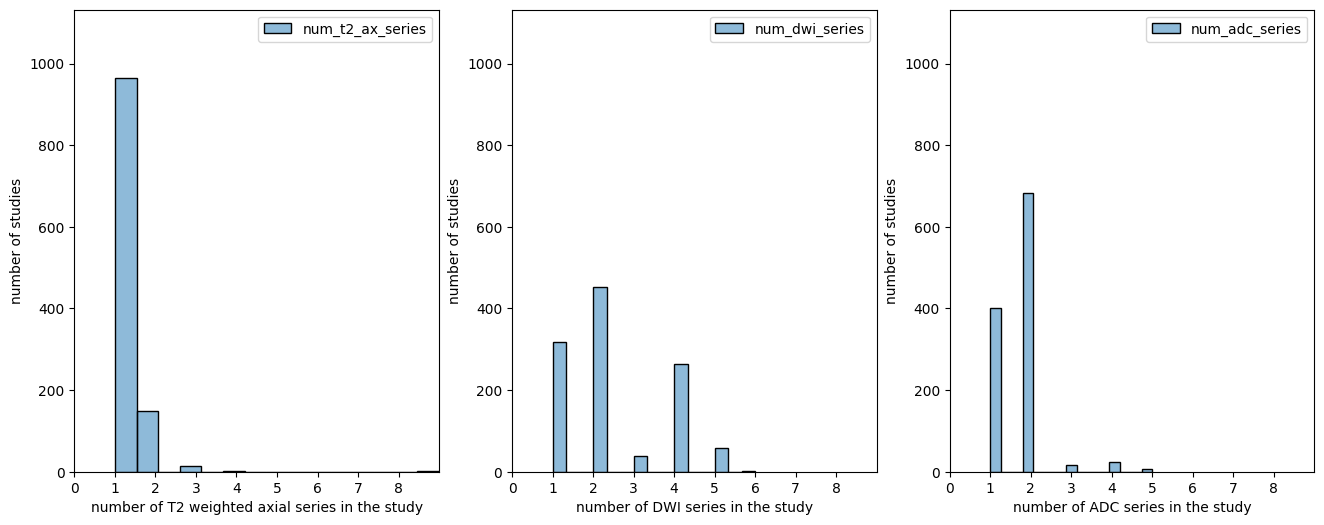

In [29]:
# Plot the T2 axial histogram
# for each study - have a number of T2 series
# plot this frequency of how many studies have each number of T2 series

df_t2 = df[['StudyInstanceUID', 'num_t2_ax_series']]
df_dwi = df[['StudyInstanceUID', 'num_dwi_series']]
df_adc = df[['StudyInstanceUID', 'num_adc_series']]
num_studies = len(df_t2)
max_num_series = np.max([np.max(df_t2['num_t2_ax_series'].values),
                         np.max(df_dwi['num_dwi_series'].values),
                         np.max(df_adc['num_adc_series'].values)])

fig = plt.figure(figsize=(16,6))

plt.subplot(1,3,1)
ax = sns.histplot(data=df_t2, bins=15)
ax.set(xlabel='number of T2 weighted axial series in the study', ylabel='number of studies')
ax.set(xticks=np.arange(0,max_num_series))
ax.set(xlim=[0,max_num_series])
ax.set(ylim=[0,num_studies])

plt.subplot(1,3,2)
ax = sns.histplot(data=df_dwi, bins=15)
ax.set(xlabel='number of DWI series in the study', ylabel='number of studies')
ax.set(xticks=np.arange(0,max_num_series))
ax.set(xlim=[0,max_num_series])
ax.set(ylim=[0,num_studies])

plt.subplot(1,3,3)
ax = sns.histplot(data=df_adc, bins=15)
ax.set(xlabel='number of ADC series in the study', ylabel='number of studies')
ax.set(xticks=np.arange(0,max_num_series))
ax.set(xlim=[0,max_num_series])
ax.set(ylim=[0,num_studies])
